# GC bias

In [150]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS (NGI)",
    "aviti_hq": "AVITI CB (HQ)",
    "xplus_sns": "NovaSeqX+ (S&S)",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/differential_coverage")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2025-02-18T10:13:14.010806+01:00

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.28.0

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 24.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 11
Architecture: 64bit



In [4]:
%watermark -iv

numpy     : 2.1.1
pandas    : 2.2.3
seaborn   : 0.13.2
matplotlib: 3.9.2



In [108]:
def files():
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2", "REH"]
    for run in runs:
        for cell in cells:
            file = basedir / f"picard/{run}_{cell}.gc_bias_metrics.txt"
            yield run, cell, file

In [83]:
data = []
for run, cell, file in files():
    d = pd.read_csv(file, header=0, comment="#", sep="\t")
    d["run"] = run
    d["Cell line"] = cell
    data.append(d)
    #break
data = pd.concat(data).reset_index(drop=True)
data["Data source"] = data["run"].replace(run_names)
data

,ACCUMULATION_LEVEL,READS_USED,GC,WINDOWS,READ_STARTS,MEAN_BASE_QUALITY,NORMALIZED_COVERAGE,ERROR_BAR_WIDTH,SAMPLE,LIBRARY,READ_GROUP,run,Cell line,Data source
0,All Reads,ALL,0,133372,10709,15,0.618203,0.005974,NaN,NaN,NaN,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
1,All Reads,ALL,1,96782,4785,15,0.380657,0.005503,NaN,NaN,NaN,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
2,All Reads,ALL,2,112190,5567,16,0.382044,0.005120,NaN,NaN,NaN,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
3,All Reads,ALL,3,143192,14265,19,0.767008,0.006422,NaN,NaN,NaN,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
4,All Reads,ALL,4,154545,9625,16,0.479504,0.004888,NaN,NaN,NaN,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,All Reads,ALL,96,986,251908,16,584.243421,1.164053,NaN,NaN,NaN,xplus_sns,REH,NovaSeqX+ (S&S)
1208,All Reads,ALL,97,658,3802144,16,13213.913307,6.776683,NaN,NaN,NaN,xplus_sns,REH,NovaSeqX+ (S&S)
1209,All Reads,ALL,98,328,1233623,17,8600.771306,7.743658,NaN,NaN,NaN,xplus_sns,REH,NovaSeqX+ (S&S)
1210,All Reads,ALL,99,133,375742,18,6460.511256,10.539549,NaN,NaN,NaN,xplus_sns,REH,NovaSeqX+ (S&S)


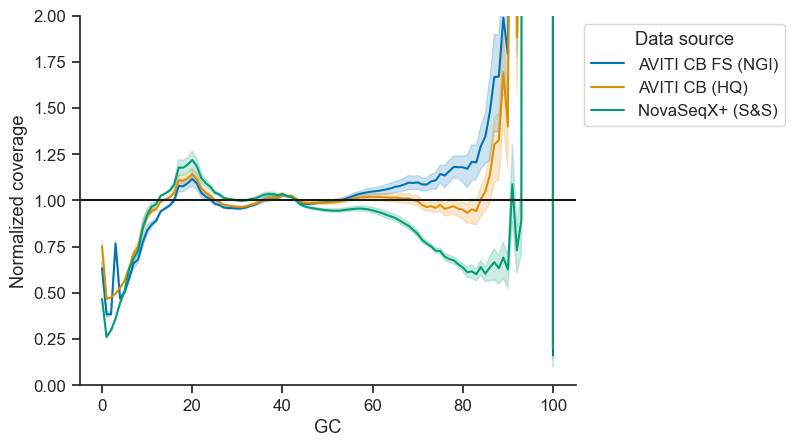

In [84]:
#ax = sns.lineplot(data, x="GC", y="NORMALIZED_COVERAGE", hue="Data source", hue_order=run_names.values(), style="cell",)
ax = sns.lineplot(data, x="GC", y="NORMALIZED_COVERAGE", hue="Data source", hue_order=run_names.values())
ax.axhline(1, color="k")
ax.set_ylabel("Normalized coverage")
ax.set_ylim(0,2)
sns.move_legend(ax, loc="best", bbox_to_anchor=(1,1))


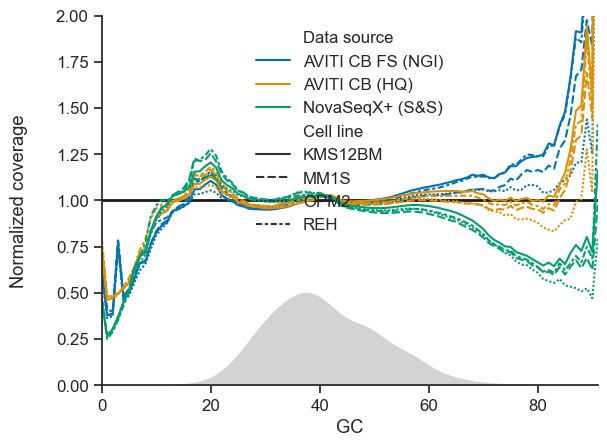

In [222]:

#fig, ax = plt.subplots(figsize=(9,4))
d = data[data["WINDOWS"] > 10_000]
ax = sns.lineplot(d, x="GC", y="NORMALIZED_COVERAGE", hue="Data source", 
                  style="Cell line", hue_order=run_names.values())
ax.axhline(1, color="k", zorder=-2, lw=2)
ax.set_ylabel("Normalized coverage", labelpad=20)
ax.set_ylim(0,2)
ax.set_xlim(d["GC"].min(),d["GC"].max())
ax.legend(frameon=False, framealpha=0)

#sns.move_legend(ax, loc="center left", bbox_to_anchor=(1,0.5))
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5,1))

# Add heatmap with relative bin abundance in GRCh38
for _, d in d.groupby(["Data source", "Cell line"]):
    break
y = (d["WINDOWS"] / d["WINDOWS"].max()).values  / 2
x = d["GC"]
ax.fill_between(x, y, color="lightgrey")

fig = ax.get_figure()
fig.savefig(figdir / "gc_bias_w_relative_abundance.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')


In [164]:
dgc = pd.read_csv(basedir / "multiqc_data/multiqc_picard_gcbias.txt", sep="\t")
dgc["run"] = dgc["Sample"].apply(lambda x: "_".join(x.split("_")[:2]))
dgc["Cell line"] = dgc["Sample"].apply(lambda x: x.split(".")[0].split("_")[-1])
dgc["Data source"] = dgc["run"].replace(run_names)
dgc

,Sample,ACCUMULATION_LEVEL,READS_USED,WINDOW_SIZE,TOTAL_CLUSTERS,ALIGNED_READS,AT_DROPOUT,GC_DROPOUT,GC_NC_0_19,GC_NC_20_39,GC_NC_40_59,GC_NC_60_79,GC_NC_80_100,SAMPLE,LIBRARY,READ_GROUP,run,Cell line,Data source
0,aviti_hq_KMS12BM.gc_summary_metrics,All Reads,ALL,100.0,540858942.0,1.080197e+09,1.130151,0.000651,1.036159,0.981607,1.012693,1.044163,1.692226,NaN,NaN,NaN,aviti_hq,KMS12BM,AVITI CB (HQ)
1,aviti_hq_MM1S.gc_summary_metrics,All Reads,ALL,100.0,527507190.0,1.053588e+09,0.877935,0.208667,1.063724,1.001690,0.997144,0.989527,1.572595,NaN,NaN,NaN,aviti_hq,MM1S,AVITI CB (HQ)
2,aviti_hq_OPM2.gc_summary_metrics,All Reads,ALL,100.0,528032842.0,1.054704e+09,0.832761,0.122947,1.020965,0.998557,1.001139,0.991445,1.437433,NaN,NaN,NaN,aviti_hq,OPM2,AVITI CB (HQ)
3,aviti_hq_REH.gc_summary_metrics,All Reads,ALL,100.0,476637221.0,9.519524e+08,0.910886,0.060492,1.072494,0.994523,1.001318,1.020132,1.603157,NaN,NaN,NaN,aviti_hq,REH,AVITI CB (HQ)
4,aviti_ngi_KMS12BM.gc_summary_metrics,All Reads,ALL,100.0,190841799.0,3.811419e+08,1.429607,0.000009,1.002128,0.975479,1.013549,1.101468,1.837993,NaN,NaN,NaN,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
5,aviti_ngi_MM1S.gc_summary_metrics,All Reads,ALL,100.0,191981149.0,3.834485e+08,1.136153,0.106873,1.033342,0.996032,0.998145,1.040524,1.689806,NaN,NaN,NaN,aviti_ngi,MM1S,AVITI CB FS (NGI)
6,aviti_ngi_OPM2.gc_summary_metrics,All Reads,ALL,100.0,216340078.0,4.321437e+08,1.119055,0.042087,0.978128,0.993039,1.002457,1.040651,1.510651,NaN,NaN,NaN,aviti_ngi,OPM2,AVITI CB FS (NGI)
7,aviti_ngi_REH.gc_summary_metrics,All Reads,ALL,100.0,163839111.0,3.271838e+08,1.269873,0.013493,1.036647,0.985579,1.003751,1.089933,1.809271,NaN,NaN,NaN,aviti_ngi,REH,AVITI CB FS (NGI)
8,xplus_sns_KMS12BM.gc_summary_metrics,All Reads,ALL,100.0,696812854.0,1.389977e+09,0.667224,0.836141,1.085891,1.013753,0.984374,0.926550,4.635674,NaN,NaN,NaN,xplus_sns,KMS12BM,NovaSeqX+ (S&S)
9,xplus_sns_MM1S.gc_summary_metrics,All Reads,ALL,100.0,689894441.0,1.376873e+09,0.943511,1.497095,1.122806,1.032923,0.967590,0.880589,5.091767,NaN,NaN,NaN,xplus_sns,MM1S,NovaSeqX+ (S&S)


In [165]:
dgc.columns

Index(['Sample', 'ACCUMULATION_LEVEL', 'READS_USED', 'WINDOW_SIZE',
       'TOTAL_CLUSTERS', 'ALIGNED_READS', 'AT_DROPOUT', 'GC_DROPOUT',
       'GC_NC_0_19', 'GC_NC_20_39', 'GC_NC_40_59', 'GC_NC_60_79',
       'GC_NC_80_100', 'SAMPLE', 'LIBRARY', 'READ_GROUP', 'run', 'Cell line',
       'Data source'],
      dtype='object')

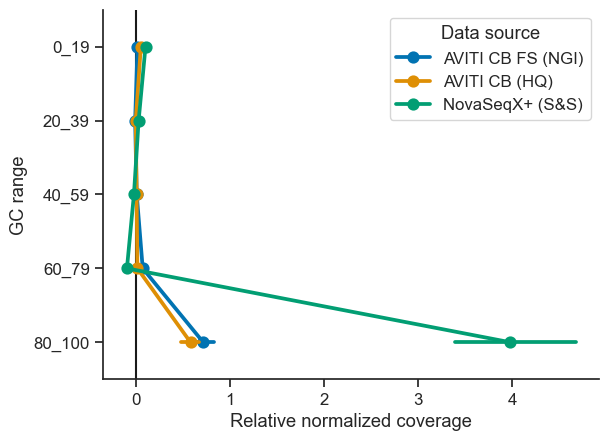

In [166]:
d = dgc.melt(value_vars=['GC_NC_0_19', 'GC_NC_20_39', 'GC_NC_40_59', 'GC_NC_60_79',
       'GC_NC_80_100'], id_vars=["Data source", "Cell line"])
d["value"] = d["value"] - 1
d["GC range"] = d["variable"].str[6:]

ax = sns.pointplot(d, y="GC range", x="value", hue="Data source", 
                   hue_order=run_names.values())
ax.set_xlabel("Relative normalized coverage")
ax.axvline(0, color="k", zorder=-1)

<Axes: xlabel='Cell line', ylabel='GC_DROPOUT'>

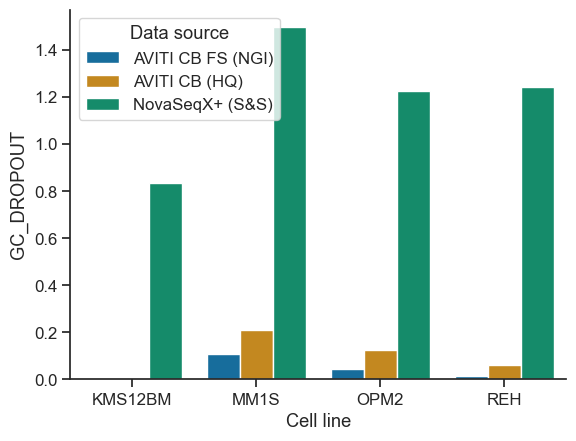

In [168]:
sns.barplot(dgc, x="Cell line", y="GC_DROPOUT", hue="Data source", hue_order=run_names.values())

<Axes: xlabel='Cell line', ylabel='AT_DROPOUT'>

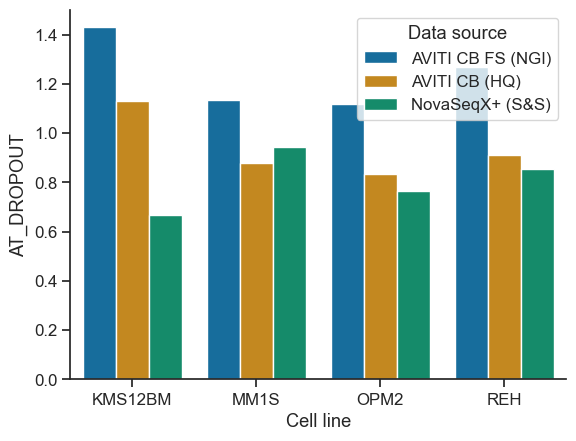

In [169]:
sns.barplot(dgc, x="Cell line", y="AT_DROPOUT", hue="Data source", hue_order=run_names.values())

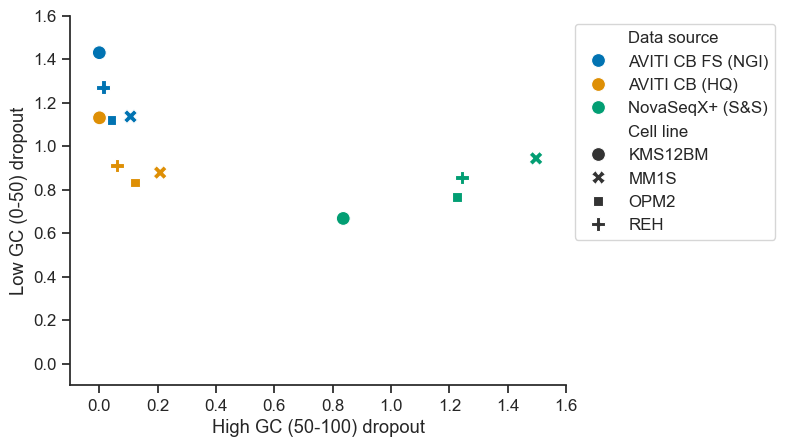

In [170]:
ax = sns.scatterplot(dgc, x="GC_DROPOUT", y="AT_DROPOUT", hue="Data source", 
                     hue_order=run_names.values(), style="Cell line", s=100)
ax.set_ylim(-0.1,1.6)
ax.set_xlim(-0.1,1.6)
ax.set_ylabel("Low GC (0-50) dropout")
ax.set_xlabel("High GC (50-100) dropout")

sns.move_legend(ax, loc="best", bbox_to_anchor=(1,1))